# Plotting results

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

from results import *
import seaborn as sns;

sns.set_theme()

## 1. Load data

In [47]:
# ec = 'gridflex'
ec = 'groenemient'

In [48]:
results = pd.read_csv(f'data/prepared/results_{ec}.csv.gz', compression='gzip')

## 2. Calculate annual values

In [49]:
results = aggregate_timeseries_data(results)

100%|██████████| 216/216 [00:01<00:00, 131.72it/s]


In [50]:
results_df = results.copy()
for i in range(0, 9):
    results_df = results_df.append(results)

In [51]:
results = results_df.copy()
results.reset_index(drop=True, inplace=True)

## 3. Feature scoring

In [52]:
experiments = results.loc[:, ['L1', 'X1', 'L2', 'X2', 'L3', 'X3']]
outcomes = results[
    ['M1_total', 'M2_total', 'M3_total_residential', 'M3_total_non_residential', 'M4_total', 'M5_total', 'M6_total']]

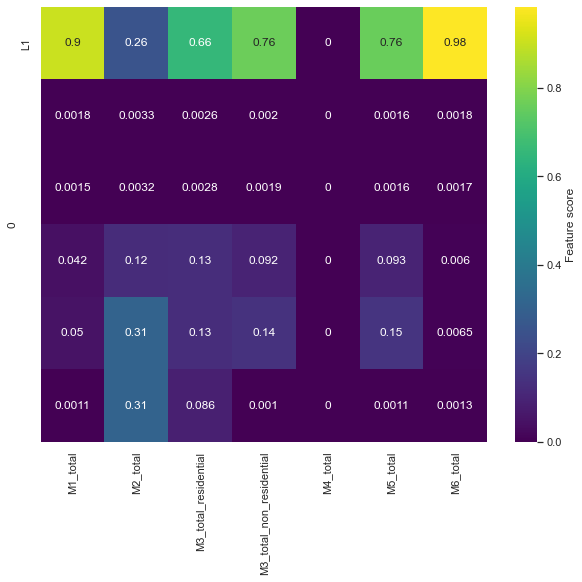

<Figure size 432x288 with 0 Axes>

In [53]:
from ema_workbench.analysis import feature_scoring

x = experiments
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y, )

fig, ax = plt.subplots(1, 1, figsize=(10, 8),)
sns.heatmap(fs, cmap="viridis", annot=True, ax=ax, cbar=True, yticklabels=20, cbar_kws={'label': 'Feature score'})
plt.show()
plt.savefig(f'data/figures/open_exploration/{ec}_feature_scores.png', dpi=300)

## 4. Scenario discovery

### 4.1 Scenario discovery for residential load shift

In [54]:
from ema_workbench.analysis import prim

x = experiments
y = outcomes['M3_total_residential'] > np.percentile(outcomes['M3_total_residential'], 80)
prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.05)
box1 = prim_alg.find_box()

coverage    0.418605
density     1.000000
id          4.000000
mass        0.083333
mean        1.000000
res_dim     3.000000
Name: 4, dtype: float64

    box 4                                      
      min   max                       qp values
L1  0.625  0.75  [1.3127261917780203e-86, -1.0]
X1  0.600  0.80   [6.525304467998525e-55, -1.0]
X2  0.750  1.00   [3.243600886976247e-23, -1.0]



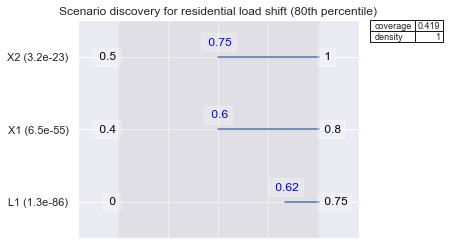

<Figure size 432x288 with 0 Axes>

In [55]:
box1.inspect()
box1.inspect(style="graph")
plt.title('Scenario discovery for residential load shift (80th percentile)')
plt.show()
plt.savefig(f'data/figures/open_exploration/{ec}_prim_box1_residential_load.png', dpi=300)

### 4.2 Dimensional stacking for residential load shift

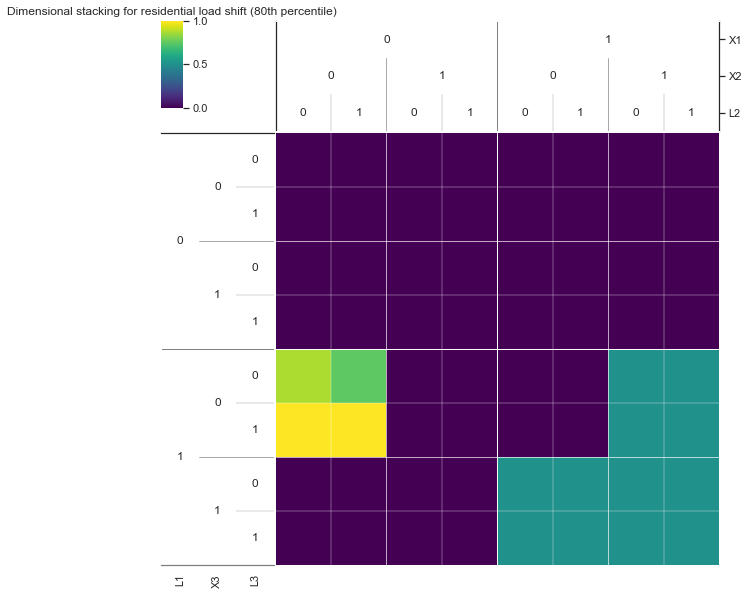

<Figure size 432x288 with 0 Axes>

In [56]:
from ema_workbench.analysis import dimensional_stacking

x = experiments
y = outcomes['M3_total_residential'] > np.percentile(outcomes['M3_total_residential'], 80)

dimensional_stacking.create_pivot_plot(x, y, nbins=2)
plt.title('Dimensional stacking for residential load shift (80th percentile)')
plt.show()
plt.savefig(f'data/figures/open_exploration/{ec}_dimensional_stacking_residential.png', dpi=300)

### 4.3 Scenario discovery for overall load shift

In [57]:
data = results['M3_total']
outcomes = data > np.percentile(data, 80)
experiments = results.loc[:, ['L1', 'X1', 'L2', 'X2', 'L3', 'X3']]

In [58]:
prim_alg = prim.Prim(y=outcomes, x=experiments, threshold=0.8)
box1 = prim_alg.find_box()

coverage    0.837209
density     1.000000
id          3.000000
mass        0.166667
mean        1.000000
res_dim     2.000000
Name: 3, dtype: float64

    box 3                                       
      min   max                        qp values
L1  0.625  0.75  [1.7232500545800236e-172, -1.0]
X2  0.750  1.00   [2.5641610174914073e-81, -1.0]



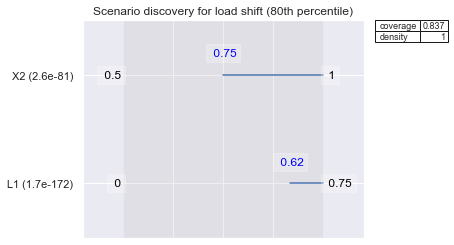

<Figure size 432x288 with 0 Axes>

In [59]:
box1.inspect()
box1.inspect(style='graph')
plt.title('Scenario discovery for load shift (80th percentile)')
plt.show()
plt.savefig(f'data/figures/open_exploration/{ec}_prim_box2_shifted_load.png', dpi=300)

### 4.4 Dimensional stacking for overall load shift

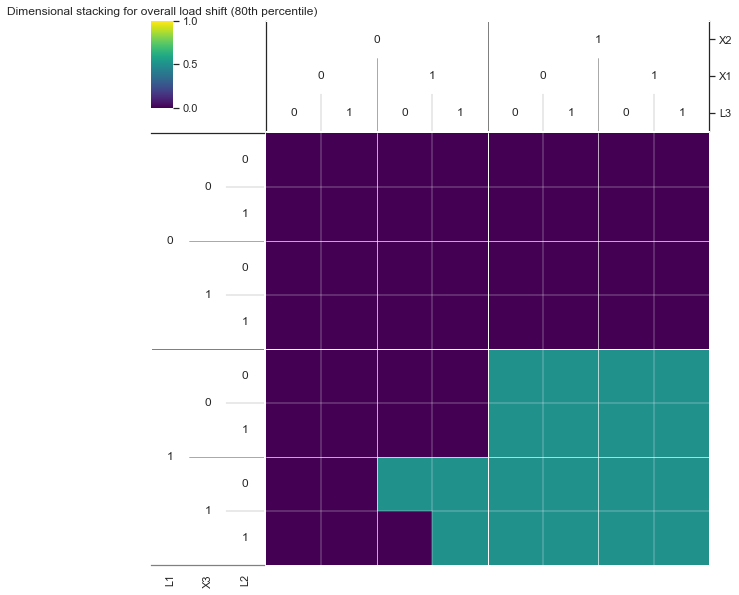

<Figure size 432x288 with 0 Axes>

In [60]:
from ema_workbench.analysis import dimensional_stacking

dimensional_stacking.create_pivot_plot(experiments, outcomes, nbins=2)
plt.title('Dimensional stacking for overall load shift (80th percentile)')
plt.show()
plt.savefig(f'data/figures/open_exploration/{ec}_dimensional_stacking_shifted_load.png', dpi=300)

## 5. Visual analysis

In [61]:
columns = ['M3_total_residential', 'M3_total_non_residential', 'M6_total']

In [62]:
policies = {1: {'L1': 0.75, 'L2': 1.0, 'L3': 0.45},
            2: {'L1': 0.5, 'L2': 0.5, 'L3': 0.45},}

In [63]:
col = results.columns.to_list()
col.append('policy')
df = pd.DataFrame(columns=col)
for key in policies.keys():
    L1, L2, L3 = policies[key].values()
    df = df.append(results.loc[(results['L1'] == L1) & (results['L2'] == L2) & (results['L3'] == L3)])

In [64]:
for key in policies.keys():
    L1, L2, L3 = policies[key].values()
    df.loc[(df['L1'] == L1) & (df['L2'] == L2) & (df['L3'] == L3), 'policy'] = key

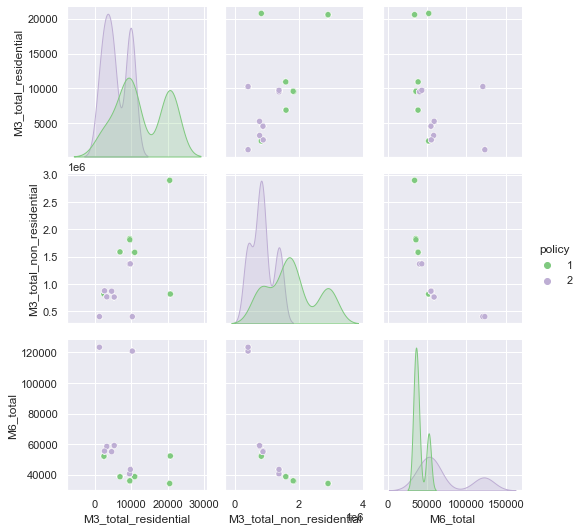

<Figure size 432x288 with 0 Axes>

In [65]:
sns.pairplot(df, vars=columns, hue='policy', diag_kind='kde', diag_kws=dict(shade=True), palette='Accent')
# plt.title('Key performance metrics for (1) optimistic policy and (2) realistic policy', fontsize=20, fontweight='bold',)
plt.show()
plt.tight_layout()
plt.savefig(f'data/figures/open_exploration/{ec}_pairplot.png', dpi=300)